https://github.com/fastai/fastbook/blob/master/02_production.ipynb

https://course.fast.ai/images

# Setup

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 10.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.1 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 189 kB 37.9 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 332 kB/s 


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
import pathlib
from fastbook import *
from fastai.vision.widgets import *

# Loading the Data

In [4]:
# getting the path
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/fastai/'
path = pathlib.Path(base_dir)
path.ls()

(#5) [Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/02_production_v2.ipynb'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/01_intro.ipynb'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/pets-classification'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/02_production_v1.ipynb'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears')]

In [ ]:
# download and saving all the images
bear_types = ['grizzly', 'black', 'teddy']
bears_path = (path/'bears')

if not bears_path.exists():
    bears_path.mkdir(exist_ok=True)
    for bear_type in bear_types:    
        dest = (path/'bears'/bear_type)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{bear_type} bear')
        download_images(dest, urls=results)

In [7]:
# pega o endereço completo de cada arquivo de imagem
fns = get_image_files(bears_path)
fns

(#771) [Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000003.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000000.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000001.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000005.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000009.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000006.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000004.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000008.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000007.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000013.jpg')...]

In [8]:
# 776 imagens coletadas
len(fns)

771

In [ ]:
# verificando imagens corruptas
failed = verify_images(fns)
failed

(#5) [Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/grizzly/00000108.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/black/00000273.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/teddy/00000037.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/teddy/00000103.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/fastai/bears/teddy/00000144.png')]

In [ ]:
# 5 imagens corruptas
len(failed)

5

In [ ]:
# eliminando as imagens corruptas
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [ ]:
# verificando se as imagens corrompidas foram realmente eliminadas
fns = get_image_files(bears_path)
failed = verify_images(fns)
failed

(#0) []

# From Data to DataLoaders

In [49]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [50]:
dls = bears.dataloaders(bears_path)

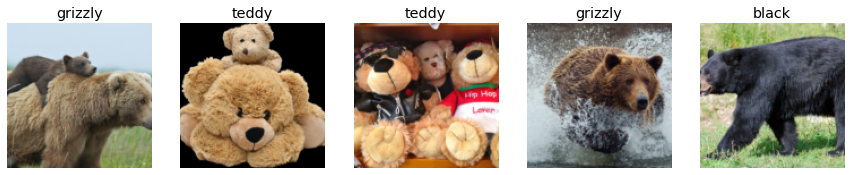

In [51]:
dls.valid.show_batch(max_n=5, nrows=1)

In [53]:
dls.vocab

['black', 'grizzly', 'teddy']

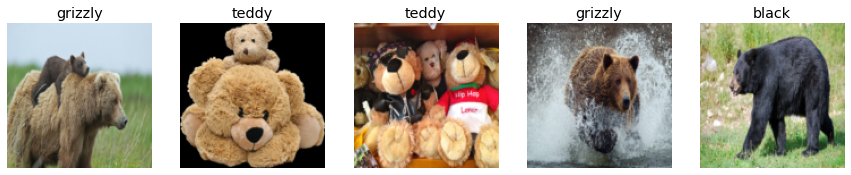

In [54]:
# Squish/Stretch images
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(bears_path)
dls.valid.show_batch(max_n=5, nrows=1)

In [56]:
dls.vocab

['black', 'grizzly', 'teddy']

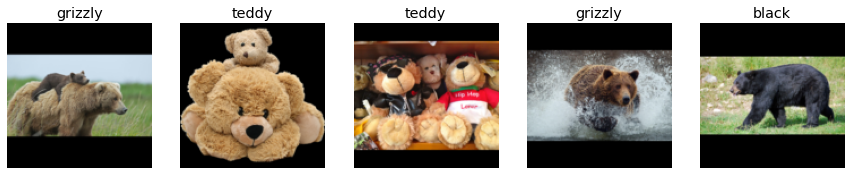

In [57]:
# Pad with zeros
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(bears_path)
dls.valid.show_batch(max_n=5, nrows=1)

In [58]:
dls.vocab

['black', 'grizzly', 'teddy']

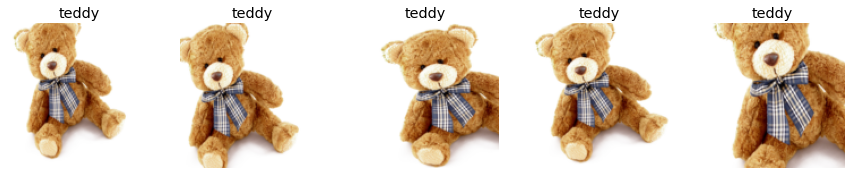

In [59]:
# One example of Data Augmentation
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(bears_path)
dls.train.show_batch(max_n=5, nrows=1, unique=True)

In [60]:
dls.vocab

['black', 'grizzly', 'teddy']

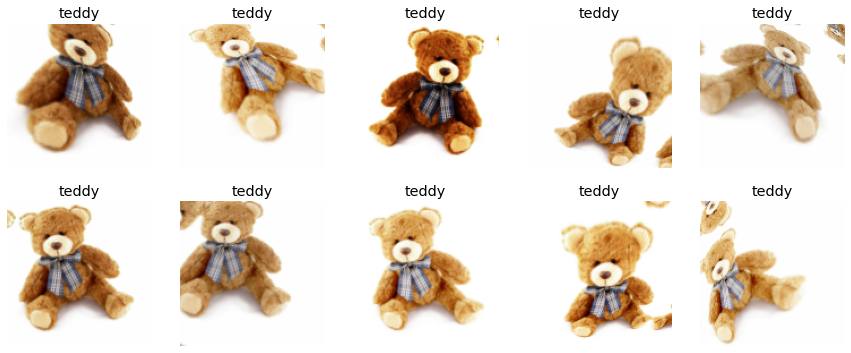

In [61]:
# Full Data Augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(bears_path)
dls.train.show_batch(max_n=10, nrows=2, unique=True)

In [62]:
dls.vocab

['black', 'grizzly', 'teddy']

# Training the Model and Using it to Clean your Data

In [63]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms())

dls = bears.dataloaders(bears_path)

In [64]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [65]:
learn.fine_tune(epochs=4) 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

In [66]:
learn.dls.vocab

['black', 'grizzly', 'teddy']

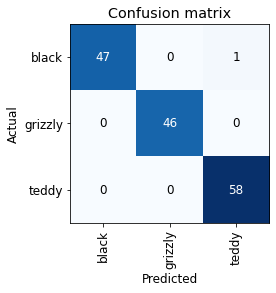

In [67]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

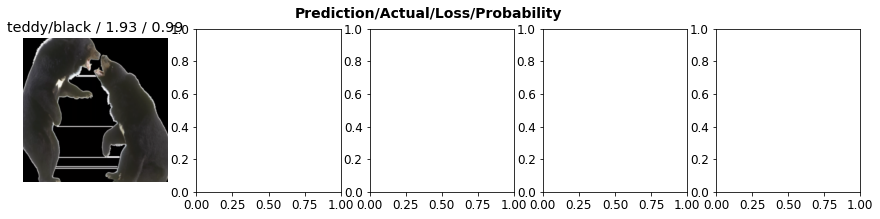

In [68]:
interp.plot_top_losses(5, nrows=1)

In [69]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# to delete (unlink) all images selected for deletion
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

In [34]:
# To move images for which we've selected a different category
for idx, cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), bears_path/cat)

# Save your Model for Inference

In [71]:
learn.export(fname=path/'models/model.pkl')

In [72]:
learn_inf = load_learner(fname=path/'models/model.pkl')

In [73]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [74]:
learn_inf.predict(bears_path/'teddy/00000000.jpg')

('teddy', tensor(2), tensor([2.5093e-08, 4.4102e-05, 9.9996e-01]))

# Creating a Notebook App from the Model

In [89]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [90]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [91]:
btn_upload.observe(on_data_change, names=['data'])

In [92]:
display(VBox([widgets.Label('Select your bear!'), btn_upload, out_pl, lbl_pred]))